# SMS Spam Detection

In [1]:
# Importing Library
import nltk
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [2]:
# Loading dataset credits
df=pd.read_csv("spam.csv",encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 1. Data Cleaning

In [3]:
# drop last 3 columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# rename columns
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# label encoder
le=LabelEncoder()
df['target']=le.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# check missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [7]:
# check missing values
df.duplicated().sum()

403

In [8]:
# remove duplicate values
df=df.drop_duplicates(keep='first')
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.shape

(5169, 2)

## 2. EDA

In [10]:
# checking counts of SPAM and not SPAM
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

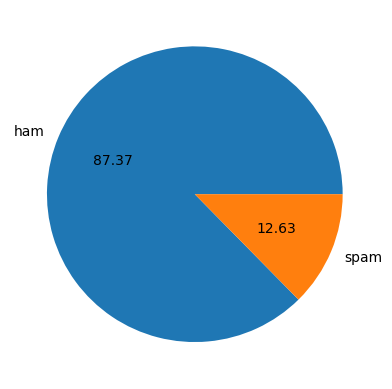

In [11]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

* Data is imbalanced

In [12]:
# import nltk
# nltk.download('punkt')

In [13]:
# Add no of characters
df['no_of_characters']=df['text'].apply(len)

In [14]:
# Add no of words
df['no_of_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [15]:
# Add no of sentence
df['no_of_sentence']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [16]:
df.head()

,target,text,no_of_characters,no_of_words,no_of_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [17]:
df[['no_of_characters', 'no_of_words', 'no_of_sentence']].describe()

,no_of_characters,no_of_words,no_of_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [18]:
# ham
df[df['target']==0][['no_of_characters', 'no_of_words', 'no_of_sentence']].describe()

,no_of_characters,no_of_words,no_of_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [19]:
# spam
df[df['target']==1][['no_of_characters', 'no_of_words', 'no_of_sentence']].describe()

,no_of_characters,no_of_words,no_of_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='no_of_characters', ylabel='Count'>

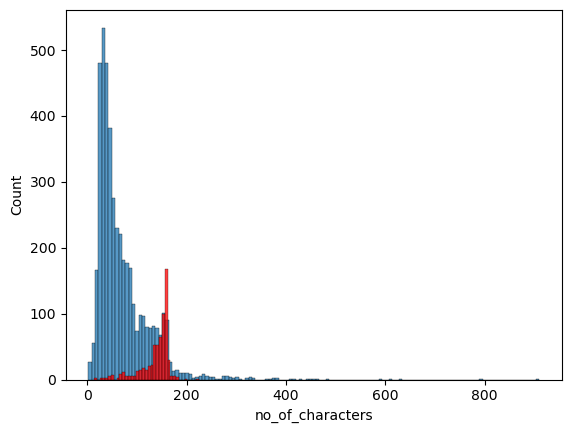

In [20]:
# hist plot for no_of_characters
import seaborn as sns
sns.histplot(df[df['target']==0]['no_of_characters'])
sns.histplot(df[df['target']==1]['no_of_characters'], color='red')

<Axes: xlabel='no_of_words', ylabel='Count'>

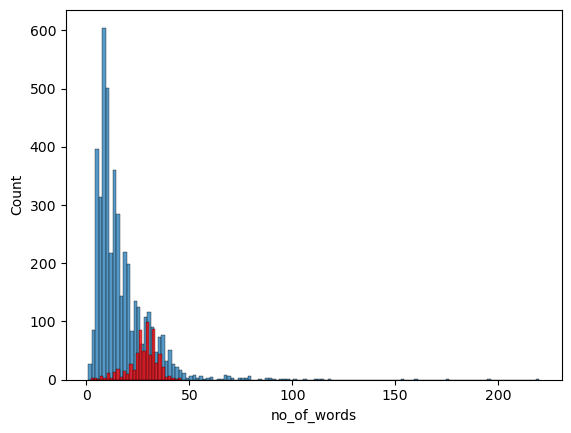

In [21]:
# hist plot for no_of_words
import seaborn as sns
sns.histplot(df[df['target']==0]['no_of_words'])
sns.histplot(df[df['target']==1]['no_of_words'], color='red')

/root/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


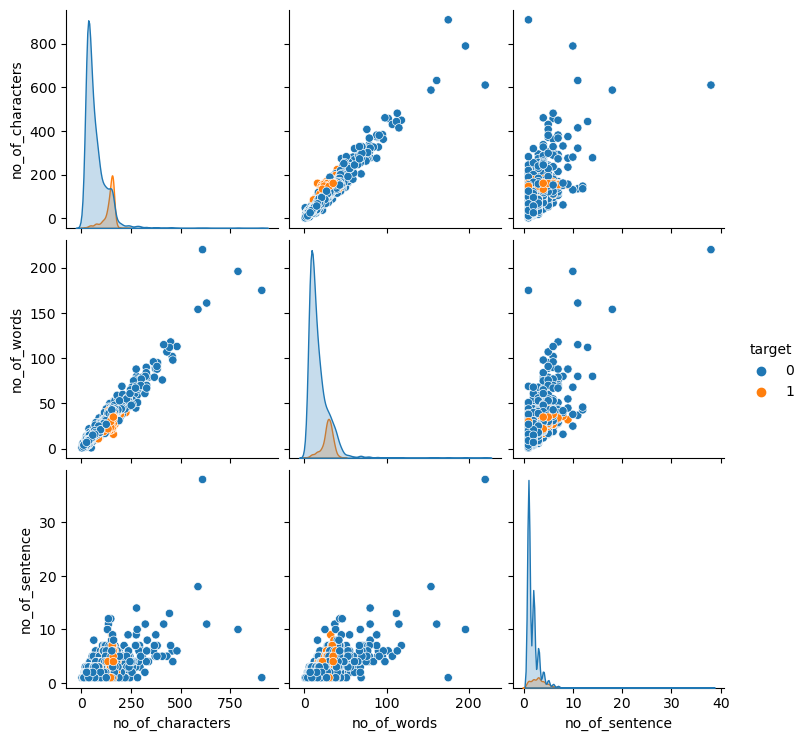

In [22]:
sns.pairplot(df,hue='target')

<Axes: >

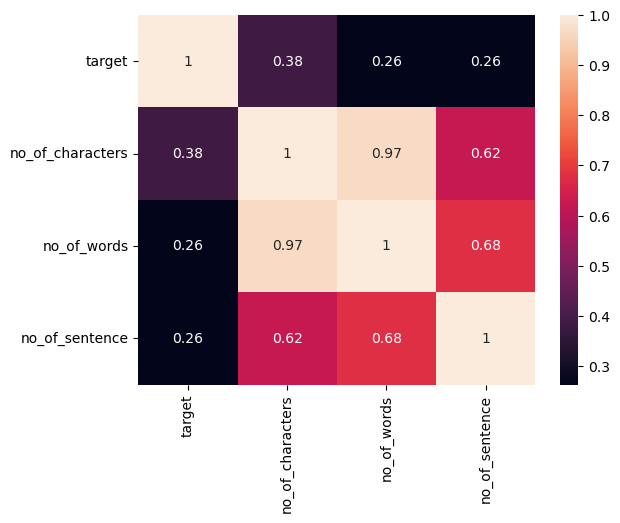

In [23]:
sns.heatmap(df[['target','no_of_characters','no_of_words','no_of_sentence']].corr(),annot=True)

## 3. Text Preprocessing

* Lower Case
* Tokenization
* Removing Special Characters
* Removing stop words
* Stemming

In [24]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

In [25]:
# Getting Stopwords
stop_words=stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [26]:
# Getting punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def preprocess_text(text):
    # Converting to lower case
    text = text.lower()
    # Word tokenization
    text = nltk.word_tokenize(text)

    # Removing special characters
    retList=[]
    for i in text:
        if i.isalnum():
            retList.append(i)

    # Removing Stop words and punctuation
    text = retList[:]
    retList.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            retList.append(i)

    # Stemming
    ps=PorterStemmer()
    text = retList[:]
    retList.clear()
    for i in text:
        retList.append(ps.stem(i))
    
    return " ".join(retList)

In [28]:
preprocess_text('Today is 29th of April 2024 @12am?')

'today 29th april 2024 12am'

In [29]:
df['transformed_text']=df['text'].apply(preprocess_text)

In [30]:
df.head()

,target,text,no_of_characters,no_of_words,no_of_sentence,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [31]:
!pip install wordcloud
from wordcloud import WordCloud
wc=WordCloud(width=500, height=500, min_font_size=10, background_color='white')

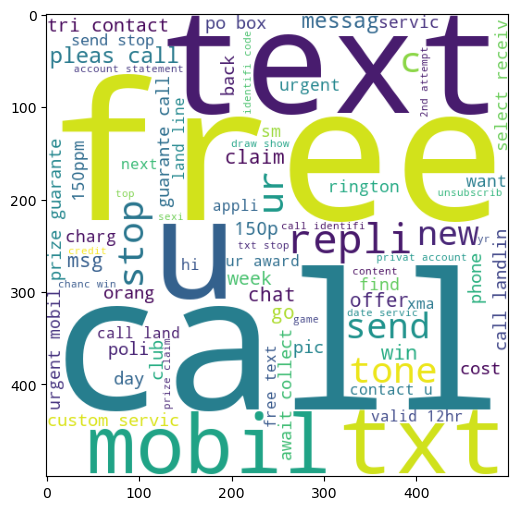

In [32]:
# Wordcloud for SPAM
spam_wc=wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

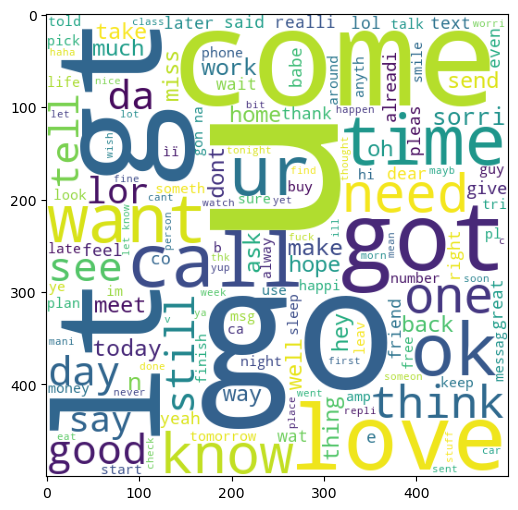

In [33]:
# Wordcloud for HAM
ham_wc=wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [34]:
spam_corpus=[]
for msg in df[df['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
print(f"Spam messages has words count of {len(spam_corpus)}")        

Spam messages has words count of 9939


In [35]:
ham_corpus=[]
for msg in df[df['target']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
print(f"Ham messages has words count of {len(ham_corpus)}")   

Ham messages has words count of 35404


In [36]:
from collections import Counter

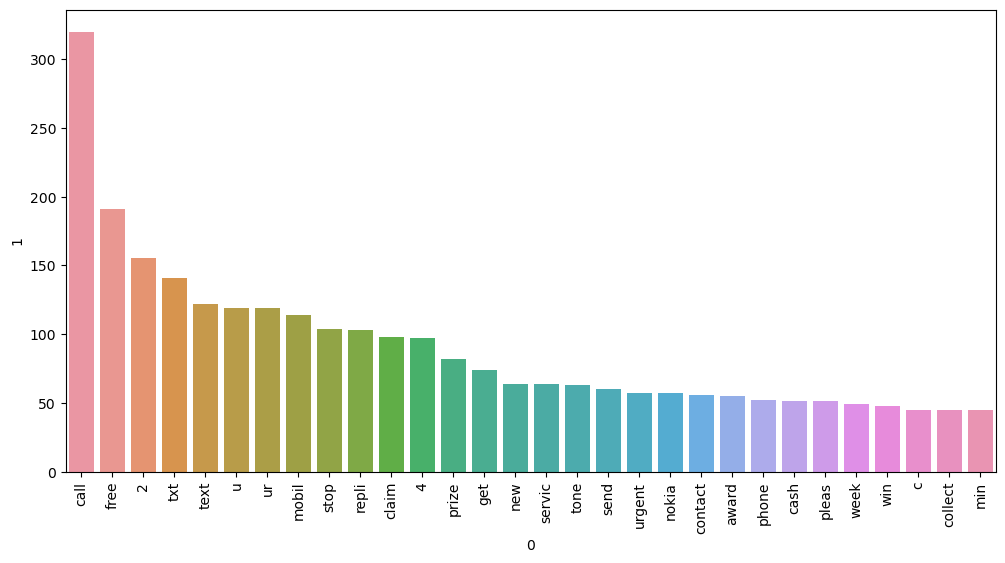

In [37]:
# Bar plot of Count of most Used words in SPAM
plt.figure(figsize=(12,6))
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

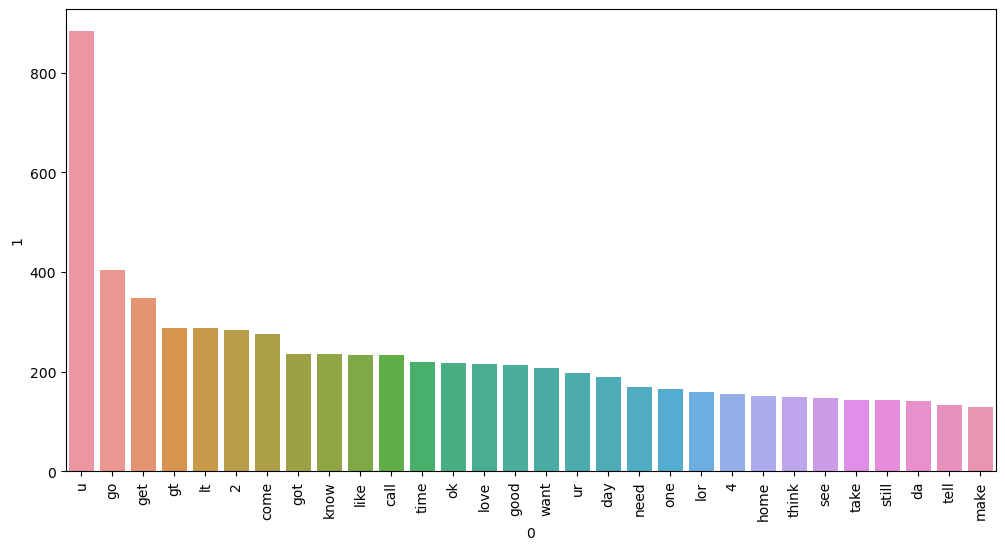

In [38]:
# Bar plot of Count of most Used words in HAM
plt.figure(figsize=(12,6))
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [39]:
Counter(ham_corpus).most_common(30)

[('u', 883),
 ('go', 404),
 ('get', 349),
 ('gt', 288),
 ('lt', 287),
 ('2', 284),
 ('come', 275),
 ('got', 236),
 ('know', 236),
 ('like', 234),
 ('call', 233),
 ('time', 219),
 ('ok', 217),
 ('love', 216),
 ('good', 213),
 ('want', 208),
 ('ur', 197),
 ('day', 190),
 ('need', 170),
 ('one', 165),
 ('lor', 159),
 ('4', 156),
 ('home', 152),
 ('think', 149),
 ('see', 147),
 ('take', 143),
 ('still', 143),
 ('da', 142),
 ('tell', 133),
 ('make', 129)]

## 4. Model Building

### 4.1 Bag of Words and Naive Bayes

In [40]:
df.head()

,target,text,no_of_characters,no_of_words,no_of_sentence,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [41]:
cv = CountVectorizer()

In [42]:
# X and y
X=cv.fit_transform(df['transformed_text']).toarray()
y=df['target'].values

In [43]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [45]:
# train_test_split
X_train,X_test, y_train,y_test=train_test_split(X,y, test_size=0.2, random_state=2)

In [46]:
# GaussianNB Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train,y_train)
y_pred_gnb=gnb.predict(X_test)
print(f"accuracy_score={accuracy_score(y_test, y_pred_gnb)}")
print(f"confusion_matrix={confusion_matrix(y_test, y_pred_gnb)}")
print(f"precision_score={precision_score(y_test, y_pred_gnb)}")

accuracy_score=0.8800773694390716
confusion_matrix=[[792 104]
 [ 20 118]]
precision_score=0.5315315315315315


In [47]:
# MultinomialNB Naive Bayes
mnb=MultinomialNB()
mnb.fit(X_train,y_train)
y_pred_mnb=mnb.predict(X_test)
print(f"accuracy_score={accuracy_score(y_test, y_pred_mnb)}")
print(f"confusion_matrix={confusion_matrix(y_test, y_pred_mnb)}")
print(f"precision_score={precision_score(y_test, y_pred_mnb)}")

accuracy_score=0.9642166344294004
confusion_matrix=[[871  25]
 [ 12 126]]
precision_score=0.8344370860927153


In [48]:
# BernoulliNB Naive Bayes
bnb=BernoulliNB()
bnb.fit(X_train,y_train)
y_pred_bnb=bnb.predict(X_test)
print(f"accuracy_score={accuracy_score(y_test, y_pred_bnb)}")
print(f"confusion_matrix={confusion_matrix(y_test, y_pred_bnb)}")
print(f"precision_score={precision_score(y_test, y_pred_bnb)}")

accuracy_score=0.9700193423597679
confusion_matrix=[[893   3]
 [ 28 110]]
precision_score=0.9734513274336283


### 4.2 Tfidf and Naive Bayes

In [49]:
cv_t=TfidfVectorizer()

In [50]:
# X and y
X=cv_t.fit_transform(df['transformed_text']).toarray()
y=df['target'].values

In [51]:
# train_test_split
X_train,X_test, y_train,y_test=train_test_split(X,y, test_size=0.2, random_state=2)

In [52]:
# GaussianNB Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train,y_train)
y_pred_gnb=gnb.predict(X_test)
print(f"accuracy_score={accuracy_score(y_test, y_pred_gnb)}")
print(f"confusion_matrix={confusion_matrix(y_test, y_pred_gnb)}")
print(f"precision_score={precision_score(y_test, y_pred_gnb)}")

accuracy_score=0.8762088974854932
confusion_matrix=[[793 103]
 [ 25 113]]
precision_score=0.5231481481481481


In [53]:
# MultinomialNB Naive Bayes
mnb=MultinomialNB()
mnb.fit(X_train,y_train)
y_pred_mnb=mnb.predict(X_test)
print(f"accuracy_score={accuracy_score(y_test, y_pred_mnb)}")
print(f"confusion_matrix={confusion_matrix(y_test, y_pred_mnb)}")
print(f"precision_score={precision_score(y_test, y_pred_mnb)}")

accuracy_score=0.9593810444874274
confusion_matrix=[[896   0]
 [ 42  96]]
precision_score=1.0


In [54]:
# BernoulliNB Naive Bayes
bnb=BernoulliNB()
bnb.fit(X_train,y_train)
y_pred_bnb=bnb.predict(X_test)
print(f"accuracy_score={accuracy_score(y_test, y_pred_bnb)}")
print(f"confusion_matrix={confusion_matrix(y_test, y_pred_bnb)}")
print(f"precision_score={precision_score(y_test, y_pred_bnb)}")

accuracy_score=0.9700193423597679
confusion_matrix=[[893   3]
 [ 28 110]]
precision_score=0.9734513274336283


MultinomialNB Naive Bayes has good Precision score with Tfidf

In [55]:
!pip install xgboost

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [57]:
svc=SVC(kernel='sigmoid', gamma=1.0)
knc=KNeighborsClassifier()
mnb=MultinomialNB()
dtc=DecisionTreeClassifier(max_depth=5)
lrc=LogisticRegression(solver='liblinear', penalty='l1')
rfc=RandomForestClassifier(n_estimators=50, random_state=2)
abc=AdaBoostClassifier(n_estimators=50, random_state=2)
bc=BaggingClassifier(n_estimators=50, random_state=2)
etc=ExtraTreesClassifier(n_estimators=50, random_state=2)
gbc=GradientBoostingClassifier(n_estimators=50, random_state=2)
xgbc=XGBClassifier(n_estimators=50, random_state=2)

In [58]:
classifiers={
    'SVC'               : svc,
    'KNeighbors'        : knc,
    'MultinomialNB'     : mnb,
    'DecisionTree'      : dtc,
    'LogisticRegression': lrc,
    'RandomForest'      : rfc,
    'AdaBoost'          : abc,
    'BaggingClassifier' : bc,
    'ExtraTrees'        : etc,
    'GradientBoosting'  : gbc,
    'XGBClassifier'     : xgbc
}

In [59]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred)

    return accuracy, precision    

In [60]:
accuracy_scores=[]
precision_scores=[]
for name, clf in classifiers.items():
    accuracy, precision=train_classifier(clf, X_train, y_train, X_test, y_test)
    print(f"Algorithm {name}: accuracy={accuracy} precision={precision}")  
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

Algorithm SVC: accuracy=0.9729206963249516 precision=0.9741379310344828
Algorithm KNeighbors: accuracy=0.9003868471953579 precision=1.0
Algorithm MultinomialNB: accuracy=0.9593810444874274 precision=1.0
Algorithm DecisionTree: accuracy=0.9352030947775629 precision=0.8380952380952381
Algorithm LogisticRegression: accuracy=0.9516441005802708 precision=0.94
Algorithm RandomForest: accuracy=0.971953578336557 precision=1.0
Algorithm AdaBoost: accuracy=0.9613152804642167 precision=0.9454545454545454
Algorithm BaggingClassifier: accuracy=0.9584139264990329 precision=0.8625954198473282
Algorithm ExtraTrees: accuracy=0.9729206963249516 precision=0.9824561403508771
Algorithm GradientBoosting: accuracy=0.9526112185686654 precision=0.9238095238095239
Algorithm XGBClassifier: accuracy=0.9729206963249516 precision=0.9435483870967742


In [61]:
performance_df=pd.DataFrame({"Algorithm": classifiers.keys(), "Accuracy": accuracy_scores, "Precision":precision_scores})

In [62]:
performance_df.head(20)

,Algorithm,Accuracy,Precision
0,SVC,0.972921,0.974138
1,KNeighbors,0.900387,1.000000
2,MultinomialNB,0.959381,1.000000
3,DecisionTree,0.935203,0.838095
4,LogisticRegression,0.951644,0.940000
5,RandomForest,0.971954,1.000000
6,AdaBoost,0.961315,0.945455
7,BaggingClassifier,0.958414,0.862595
8,ExtraTrees,0.972921,0.982456
9,GradientBoosting,0.952611,0.923810


In [63]:
performance_df.sort_values('Accuracy', ascending=False)

,Algorithm,Accuracy,Precision
0,SVC,0.972921,0.974138
8,ExtraTrees,0.972921,0.982456
10,XGBClassifier,0.972921,0.943548
5,RandomForest,0.971954,1.000000
6,AdaBoost,0.961315,0.945455
2,MultinomialNB,0.959381,1.000000
7,BaggingClassifier,0.958414,0.862595
9,GradientBoosting,0.952611,0.923810
4,LogisticRegression,0.951644,0.940000
3,DecisionTree,0.935203,0.838095


In [64]:
performance_df.sort_values('Precision', ascending=False)

,Algorithm,Accuracy,Precision
1,KNeighbors,0.900387,1.000000
2,MultinomialNB,0.959381,1.000000
5,RandomForest,0.971954,1.000000
8,ExtraTrees,0.972921,0.982456
0,SVC,0.972921,0.974138
6,AdaBoost,0.961315,0.945455
10,XGBClassifier,0.972921,0.943548
4,LogisticRegression,0.951644,0.940000
9,GradientBoosting,0.952611,0.923810
7,BaggingClassifier,0.958414,0.862595


## 5. Model Improvement

1. Change max_features parameter of tfidf
2. Feature Scaling

In [105]:
cv_imp=TfidfVectorizer(max_features=3000)

In [106]:
# X and y
X=cv_imp.fit_transform(df['transformed_text']).toarray()
y=df['target'].values

In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [107]:
# train_test_split
X_train,X_test, y_train,y_test=train_test_split(X,y, test_size=0.2, random_state=2)

In [79]:
accuracy, precision=train_classifier(mnb, X_train, y_train, X_test, y_test)
print(f"accuracy={accuracy} precision={precision}")

accuracy=0.9709864603481625 precision=1.0


In [70]:
accuracy_scores=[]
precision_scores=[]
for name, clf in classifiers.items():
    accuracy, precision=train_classifier(clf, X_train, y_train, X_test, y_test)
    print(f"Algorithm {name}: accuracy={accuracy} precision={precision}")  
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

Algorithm SVC: accuracy=0.9690522243713733 precision=0.9274193548387096
Algorithm KNeighbors: accuracy=0.9052224371373307 precision=0.9761904761904762
Algorithm MultinomialNB: accuracy=0.9787234042553191 precision=0.9461538461538461
Algorithm DecisionTree: accuracy=0.9294003868471954 precision=0.8282828282828283
Algorithm LogisticRegression: accuracy=0.9671179883945842 precision=0.9642857142857143
Algorithm RandomForest: accuracy=0.9758220502901354 precision=0.9829059829059829
Algorithm AdaBoost: accuracy=0.960348162475822 precision=0.9292035398230089
Algorithm BaggingClassifier: accuracy=0.9584139264990329 precision=0.8682170542635659
Algorithm ExtraTrees: accuracy=0.9748549323017408 precision=0.9745762711864406
Algorithm GradientBoosting: accuracy=0.9468085106382979 precision=0.9191919191919192
Algorithm XGBClassifier: accuracy=0.9671179883945842 precision=0.9262295081967213


In [71]:
performance_df_imp=pd.DataFrame({"Algorithm": classifiers.keys(), "Accuracy": accuracy_scores, "Precision":precision_scores})

#### Voting Classifier

In [99]:
from sklearn.ensemble import VotingClassifier
svc=SVC(kernel='sigmoid', gamma=1.0, probability=True)
knc=KNeighborsClassifier()
mnb=MultinomialNB()
rfc=RandomForestClassifier(n_estimators=50, random_state=2)
etc=ExtraTreesClassifier(n_estimators=50, random_state=2)

voting=VotingClassifier(estimators=[ ('KNN', knc), ('MNB', mnb), ('RF', rfc), ('ET', etc)], voting='soft')

In [100]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('MNB', MultinomialNB()),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2)),
                             ('ET',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [101]:
y_pred=voting.predict(X_test)
print(f"accuracy={accuracy_score(y_test, y_pred)} precision={precision_score(y_test, y_pred)}")  

accuracy=0.965183752417795 precision=1.0


#### Applying Stacking

In [86]:
estimators=[('SVC', svc), ('KNN', knc), ('MNB', mnb), ('RF', rfc), ('ET', etc)]
final_estimator=RandomForestClassifier(n_estimators=50, random_state=2)

In [87]:
from sklearn.ensemble import StackingClassifier

In [88]:
s_clf=StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [89]:
s_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('SVC',
                                SVC(gamma=1.0, kernel='sigmoid',
                                    probability=True)),
                               ('KNN', KNeighborsClassifier()),
                               ('MNB', MultinomialNB()),
                               ('RF',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=2)),
                               ('ET',
                                ExtraTreesClassifier(n_estimators=50,
                                                     random_state=2))],
                   final_estimator=RandomForestClassifier(n_estimators=50,
                                                          random_state=2))

In [91]:
y_pred=s_clf.predict(X_test)
print(f"accuracy={accuracy_score(y_test, y_pred)} precision={precision_score(y_test, y_pred)}")  

accuracy=0.9816247582205029 precision=0.9612403100775194


In [110]:
# MultinomialNB with max_features and without Scaling 
mnb=MultinomialNB()
mnb.fit(X_train,y_train)
y_pred=mnb.predict(X_test)
print(f"accuracy={accuracy_score(y_test, y_pred)} precision={precision_score(y_test, y_pred)}")  

accuracy=0.9709864603481625 precision=1.0


We will be using MultinomialNB with max_features and without Scaling 

In [111]:
transformed_text=preprocess_text("Hi how are you")
vector_input=cv_imp.transform([transformed_text])
y_pred_text = voting.predict(vector_input)

In [112]:
y_pred_text[0]

0